In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f7fe8eae700>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [10]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f7fe8eaeca0>,
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(date)

('2017-08-23',)


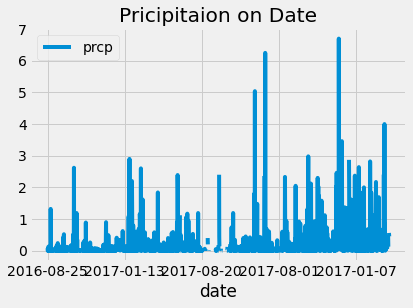

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
year_ago_date = dt.datetime(2016, 8, 24)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
df = pd.DataFrame(prcp, columns=["date", "prcp"]).set_index("date")
df.plot()
plt.title("Pricipitaion on Date")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset

total = session.query(Station.station).count()
print(f"There are {total} stations availbale in this dataset.")

There are 9 stations availbale in this dataset.


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel_count = [Measurement.station, func.count(Measurement.station)]
active = session.query(*sel_count)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
data = session.query(func.min(Measurement.tobs),
                     func.max(Measurement.tobs),
                     func.avg(Measurement.tobs))\
             .filter(Measurement.station == active[0][0]).all()

print(f"Station {active[0][0]}'s lowest temperature recorded: {data[0][0]}F")
print(f"Station {active[0][0]}'s highest temperature recorded: {data[0][1]}F")
print(f"Station {active[0][0]}'s average temperature recorded: {round(data[0][2],2)}F")

Station USC00519281's lowest temperature recorded: 54.0F
Station USC00519281's highest temperature recorded: 85.0F
Station USC00519281's average temperature recorded: 71.66F


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel_t = [Measurement.date, Measurement.tobs]
query_t = session.query(*sel_t)\
    .filter(Measurement.date >= "2016, 8, 24")\
    .filter(Measurement.station == active[0][0]).all()

temp = pd.DataFrame(query_t, columns=['Date','Temperature'])
temp = temp.dropna(how='any')
temp = temp.sort_values(["Date"], ascending=True)
temp = temp.set_index("Date")
temp

,Temperature
Date,
2016-01-01,74.0
2016-01-02,72.0
2016-01-03,68.0
2016-01-04,69.0
2016-01-05,70.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


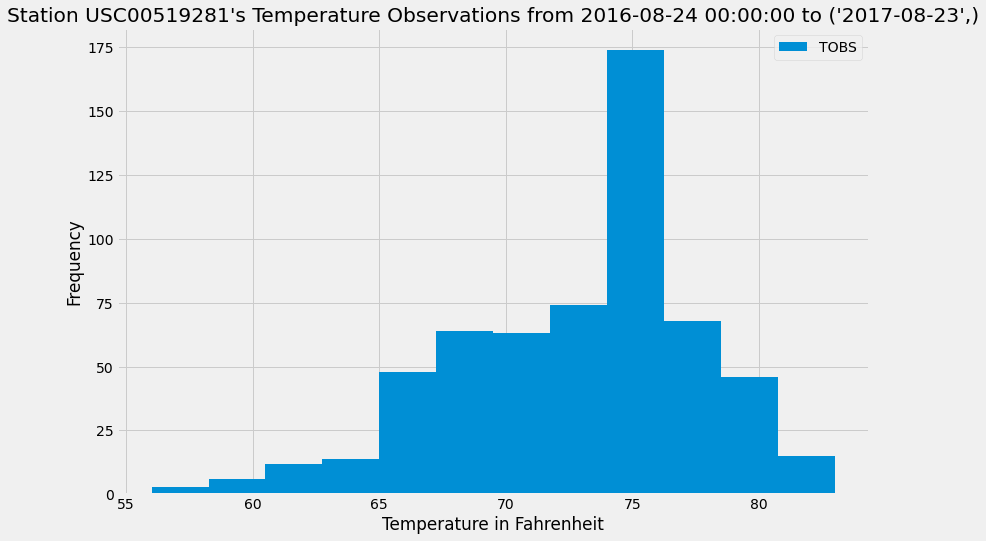

In [20]:
# Plot the results as a histogram
x = temp["Temperature"].tolist()

plt.figure(figsize=(12,8))
plt.hist(x, bins=12, label="TOBS")
plt.xlabel("Temperature in Fahrenheit")
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Station {active[0][0]}'s Temperature Observations from {year_ago_date} to {date}")
# plt.savefig("Images/hist.png")
plt.show()

# Close session

In [21]:
# Close Session
session.close()